In [17]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [145]:
%run "$utils_path"
%run "$tableGAN_path"
%load_ext line_profiler
data= pd.read_csv('.\\df_adult_edited.csv')
data
data.dtypes

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education.Num      int64
Marital.Status    object
Occupation        object
Race              object
Sex               object
Capital.Gain       int64
Hours.per.week     int64
Country           object
Salary            object
dtype: object

In [146]:
n_epochs = 20
n_critic = 10
adam_lr = 0.002
adam_beta1 = 0.5
model_dir = ".\\Model\\tableGAN_ckpt\\compare_adult\\"
noise_discrete_unif_max = 0

batch_size = 500
ckpt_every = 1
loss_plot_update_every = 10

image_dir = ".\\Images"
timer_dir = ".\\Timers"
timer_path = os.path.join(timer_dir, "timer_tgan.pkl")
retrain = True

if not os.file.exists(timer_path):
    timer = Timer()
    timer.save(timer_path)
    del timer

In [152]:
%run "$tableGAN_path"
tg = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "ref",
              quantile_transformation_int = False, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

tg_qt = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "qt",
              quantile_transformation_int = True, quantile_rand_transformation = False,
             noise_discrete_unif_max = noise_discrete_unif_max)

tg_qtr = TableGAN(data, n_critic = n_critic, adam_lr = adam_lr, adam_beta1 = adam_beta1, 
              ckpt_dir = model_dir + "qtr",
              quantile_transformation_int = True, quantile_rand_transformation = True,
             noise_discrete_unif_max = noise_discrete_unif_max)



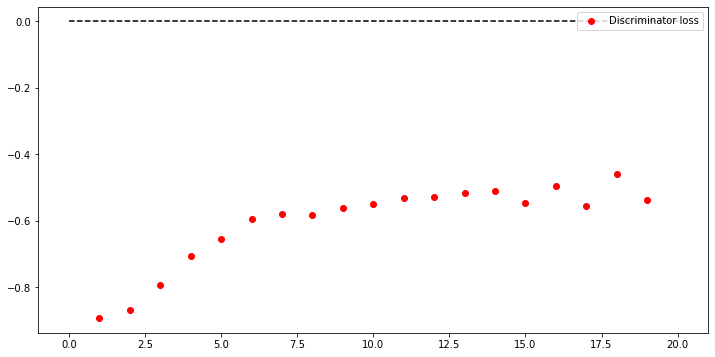

Elapsed time for tabGAN: 80.647 seconds


In [147]:
if retrain:
    timer_tgan = load_timer(timer_path)
    timer_tgan.start("tabGAN")
    fig_loss_adult, fig_time_plot = tg.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every,
                                            loss_plot_type = "line", save_dir = image_dir,
                                             filename_train_loss = "train_loss_plot_ref.jpg")
    timer_tgan.stop("tabGAN")
    timer_tgan.save(timer_path)

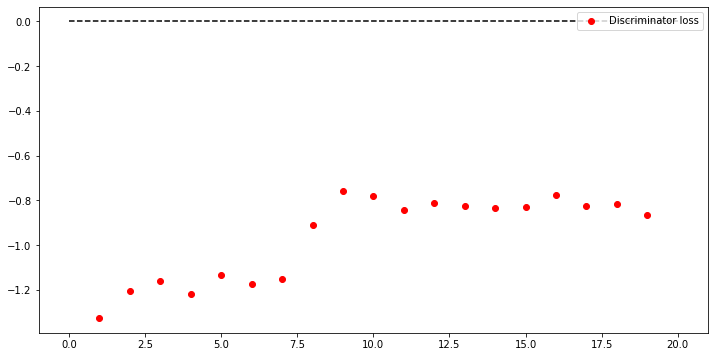

Elapsed time for tabGAN-qt: 81.778 seconds


In [150]:
if retrain:
    timer_tgan = load_timer(timer_path)
    timer_tgan.start("tabGAN-qt")
    fig_loss_adult, fig_time_plot = tg_qt.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every,
                                            loss_plot_type = "line", save_dir = image_dir,
                                             filename_train_loss = "train_loss_plot_qt.jpg")
    timer_tgan.stop("tabGAN-qt")
    timer_tgan.save(timer_path)

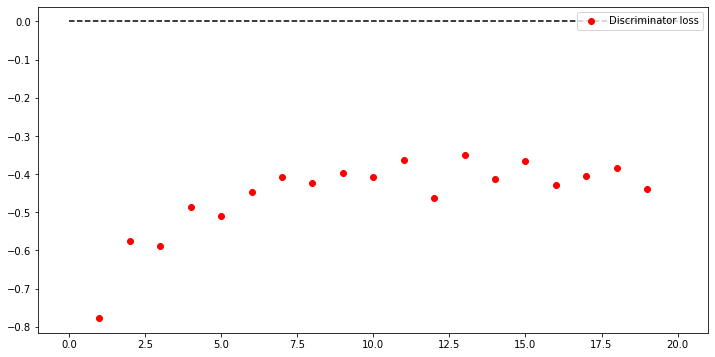

Elapsed time for tabGAN-qtr: 83.141 seconds


In [153]:
if retrain:
    timer_tgan = load_timer(timer_path)
    timer_tgan.start("tabGAN-qtr")
    fig_loss_adult, fig_time_plot = tg_qtr.train(n_epochs, batch_size = batch_size, ckpt_every = ckpt_every,
                                             restart_training = True, time_plot = True, 
                                             loss_plot_update_every = loss_plot_update_every,
                                            loss_plot_type = "line", save_dir = image_dir,
                                             filename_train_loss = "train_loss_plot_qtr.jpg")
    timer_tgan.stop("tabGAN-qtr")
    timer_tgan.save(timer_path)

In [154]:
tg.restore_checkpoint()
tg_qt.restore_checkpoint()
tg_qtr.restore_checkpoint()

compare_hist_prefix = "comp_hist_"
image_type = ".jpg"

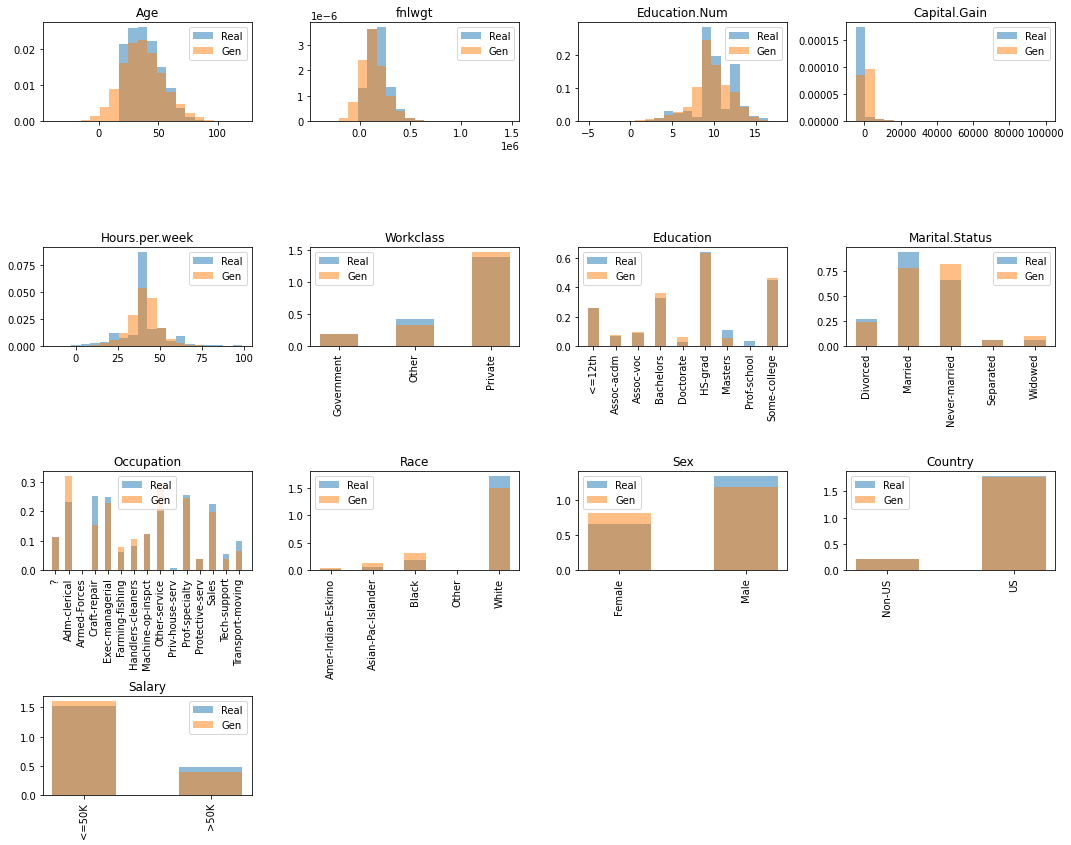

In [155]:
compare_hist_real_vs_generated(tg, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "ref" + image_type,
                              save_dir = image_dir)

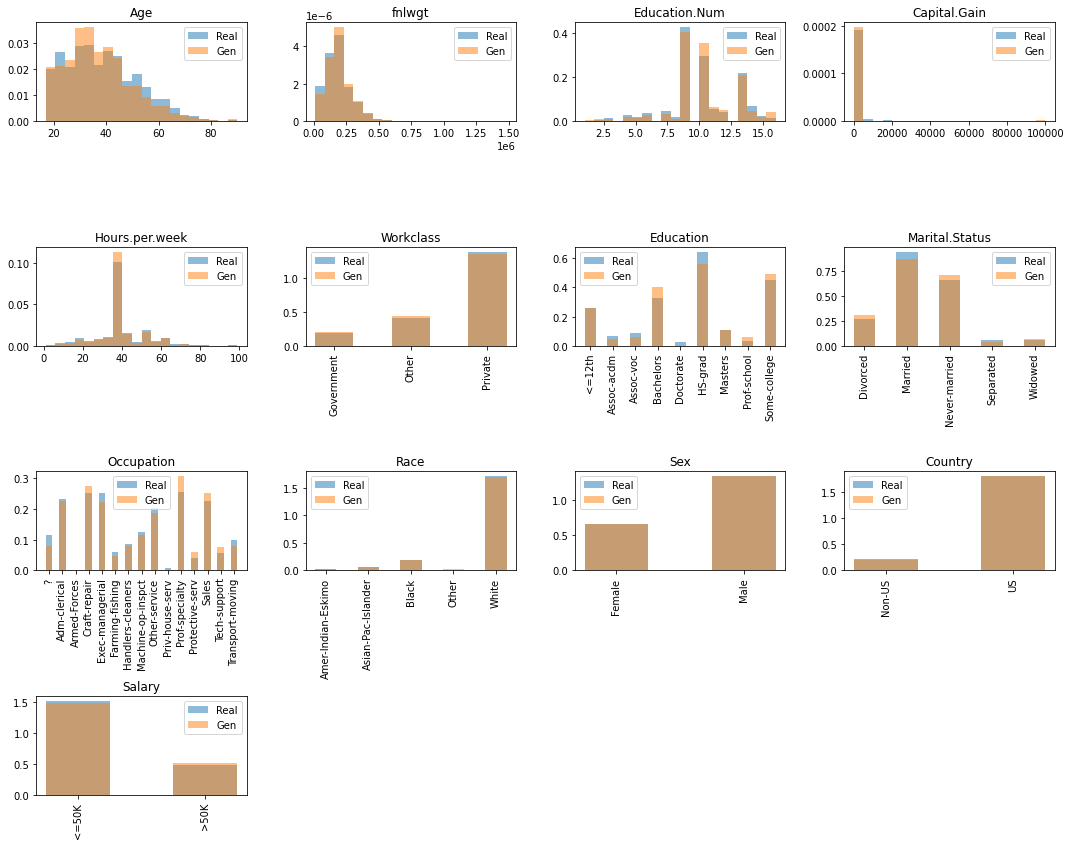

In [156]:
compare_hist_real_vs_generated(tg_qt, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "qt" + image_type,
                              save_dir = image_dir)

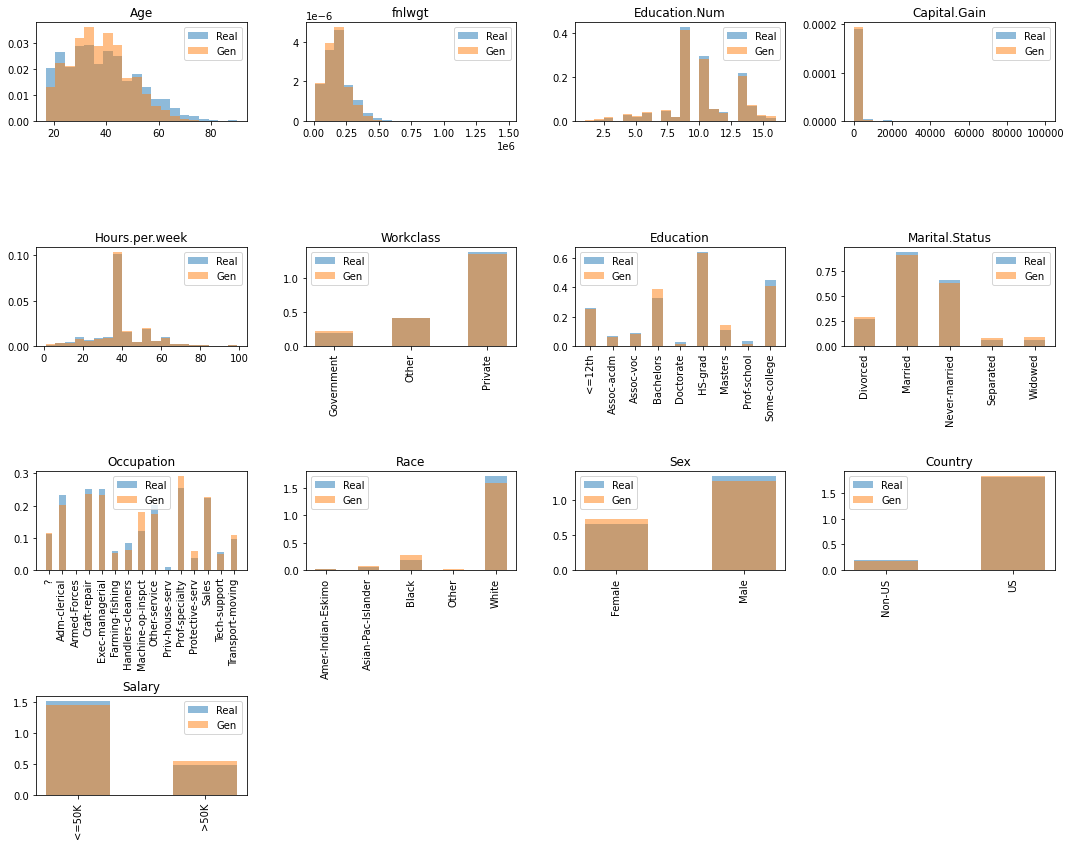

In [157]:
compare_hist_real_vs_generated(tg_qtr, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "qtr" + image_type,
                              save_dir = image_dir)

In [162]:
if retrain:
    timer_tgan = load_timer(timer_path)
    timer_tgan.start("CTGAN")
    ctgan = CTGANSynthesizer(epochs=20, discriminator_steps = n_critic)
    ctgan.fit(data, tg.columns_discrete)
    ctgan.save(model_dir + "ctgan.pkl")
    timer_tgan.stop("CTGAN")
    timer_tgan.save(timer_path)

Elapsed time for CTGAN: 618.913 seconds


In [163]:
ctgan = CTGANSynthesizer.load(model_dir + "ctgan.pkl")
ctgan_synthetic_data = ctgan.sample(tg.nrow)

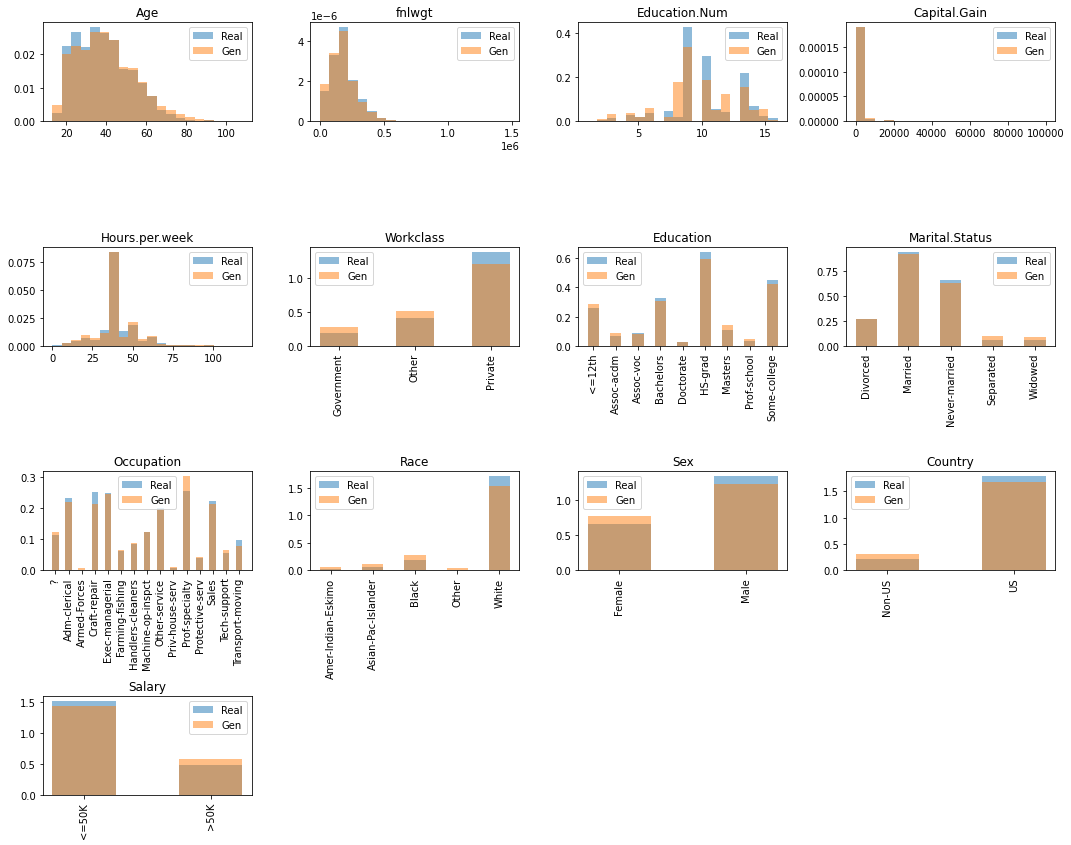

In [164]:
compare_hist_real_vs_generated(tg_qt, other_gen_dataset = ctgan_synthetic_data, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "ctgan" + image_type,
                              save_dir = image_dir)

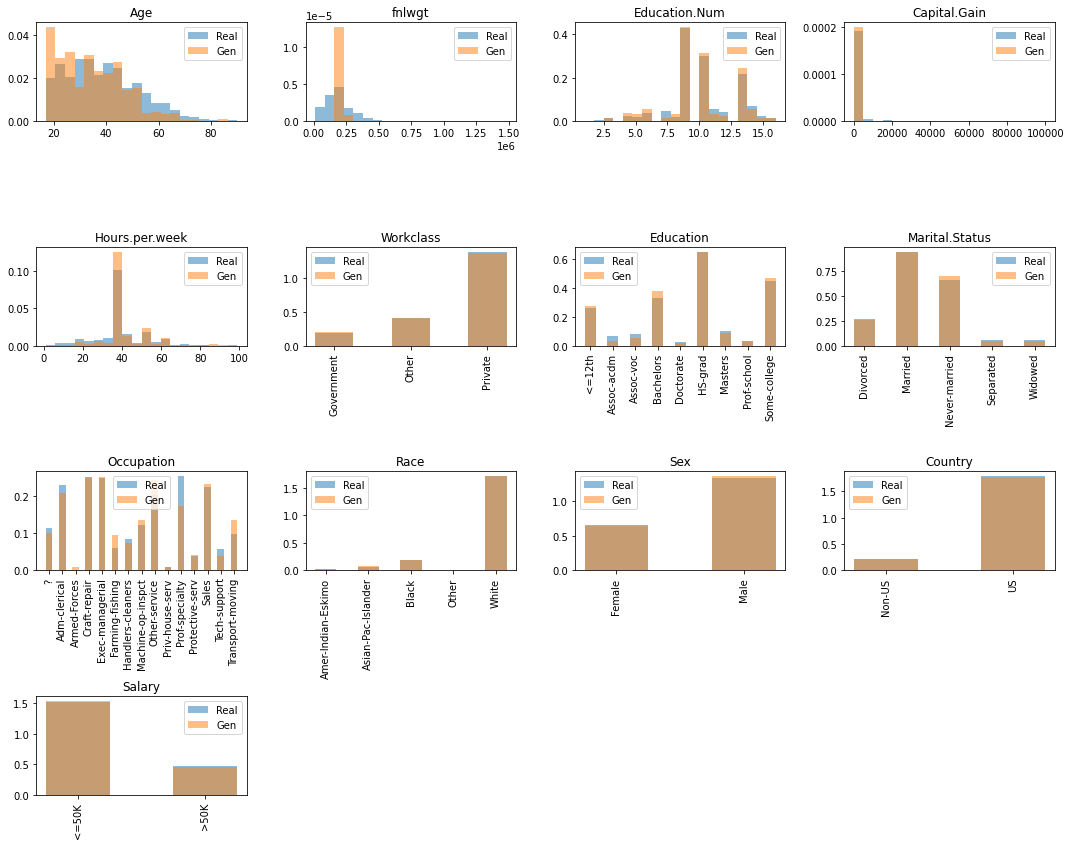

In [165]:
tgan_synthetic_data = pd.read_csv("Datasets//tgan_synthetic_dataset.csv")
compare_hist_real_vs_generated(tg_qt, other_gen_dataset = tgan_synthetic_data, discrete_xtick_rotation = 90, 
                               save_path = compare_hist_prefix + "tgan" + image_type,
                              save_dir = image_dir)

In [166]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, ctgan_synthetic_data)
# table_evaluator.visual_evaluation()


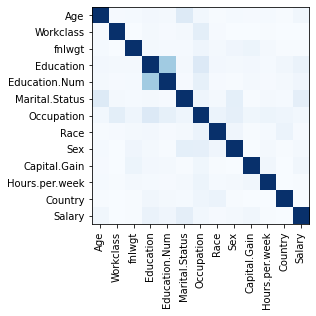

In [167]:
nmi_matrix_truth = compute_nmi_matrix(tg)
fig, ax = plt.subplots(1)
plt.imshow(nmi_matrix_truth, cmap = plt.cm.Blues, vmin = 0, vmax = 1)
xticks = ax.set_xticks(np.arange(0, nmi_matrix_truth.shape[0]))
yticks = ax.set_yticks(np.arange(0, nmi_matrix_truth.shape[0]))
xticklabels = ax.set_xticklabels(tg.columns, rotation = 90)
yticklabels = ax.set_yticklabels(tg.columns)
fig.savefig(os.path.join(image_dir, "nmi_matrix_true_dataset.jpg"))

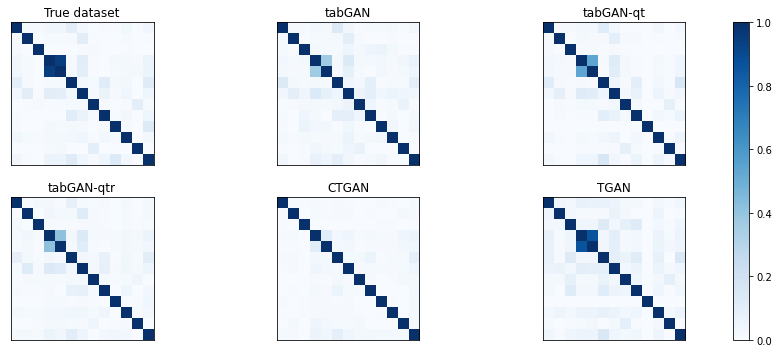

In [168]:
%run "$utils_path"
compare_nmi_matrices([tg, tg_qt, tg_qtr],
                     extra_datasets = [ctgan_synthetic_data, tgan_synthetic_data],
                     ncol = 3, subplot_titles_tgans =  ["tabGAN", "tabGAN-qt", "tabGAN-qtr"],
                     subplot_titles_extra_datasets = ["CTGAN", "TGAN"],
                    save_dir = image_dir, save_name = "nmi_matrices.jpg")

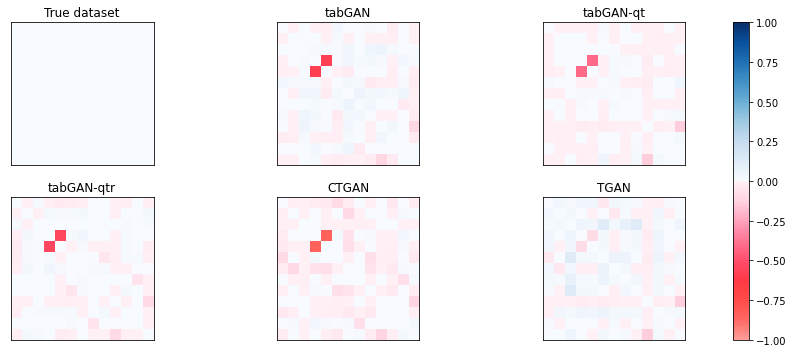

In [169]:
%run "$utils_path"
compare_nmi_matrices([tg, tg_qt, tg_qtr],
                     extra_datasets = [ctgan_synthetic_data, tgan_synthetic_data],
                     ncol = 3, subplot_titles_tgans =  ["tabGAN", "tabGAN-qt", "tabGAN-qtr"],
                     subplot_titles_extra_datasets = ["CTGAN", "TGAN"],
                    compute_diff_nmi_matrices = True, save_dir = image_dir, save_name = "nmi_diff_matrices.jpg")

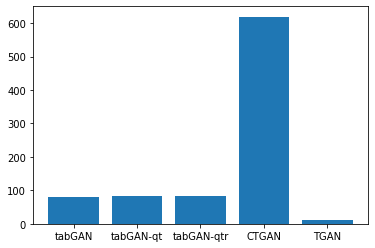

In [181]:
timer_tgan = load_timer(timer_path)
timer_tgan.elapsed_time
#models = timer_tgan.elapsed_time.keys()
models = ['tabGAN', 'tabGAN-qt', 'tabGAN-qtr', 'CTGAN', 'TGAN']
times = [timer_tgan.elapsed_time[key] for key in models]
plt.bar(models, times)
timer_tgan.elapsed_time.keys()
plt.savefig(os.path.join(image_dir, "total_train_time_plot.jpg"))